## Packages

In [1]:
import numpy as np                                # scientific computing toolkit
import pandas as pd                               # data analysis toolkit
import scanpy as sc                               # scanpy is referred to with sc.***
import matplotlib.pyplot as plt                   # Matplotlib is referred to with plt.***
from scipy import stats                           # for linear regressions
import seaborn as sns                             # for easy heatmaps
import scirpy as ir                               # TCR analysis
import scvelo as scv

sc.settings.verbosity = 3                         # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()                         # check if all needed versions are installed and up to date (old: print_Versions(), changed in new version of scanpy)
results_directory = './Analysis_output/'
results_file = results_directory + '/results_file/write/results.h5ad'     

scanpy==1.8.2 anndata==0.7.6 umap==0.5.1 numpy==1.22.1 scipy==1.7.3 pandas==1.2.4 scikit-learn==0.23.2 statsmodels==0.12.2 python-igraph==0.9.1 pynndescent==0.5.2


In [2]:
import glob
import os
#import subprocess
#import sys
from pathlib import Path

analysis_info = './analysis_info/'

plt.rcParams['figure.figsize']=(6,6) #rescale figures
sc.settings.set_figure_params(dpi=100, dpi_save=600, color_map='viridis', vector_friendly=True, format='eps')
### you can set a default figure directory here for saving output
sc.settings.figdir = "./analysis_output/figures_manuscript/"
## Figure directory for matplotlib figures/axes
save_figure_sc = "./analysis_output/figures_manuscript/"
#Use
#plt.savefig(save_figure + 'image.pdf')
save_figure_ir = "./analysis_output/figures_manuscript/"
#csv directory
read_csv = './analysis_output/results_file/'
save_csv = r'./analysis_output/results_file/'

#save figure for presentation
save_figure_pres = "./analysis_output/figures_manuscript/"

In [3]:
import batchglm.api as glm
import diffxpy.api as de

print("batchglm version "+glm.__version__)
print("diffpy version "+de.__version__)

batchglm version v0.7.4
diffpy version 0+unknown


## Read-in data

In [4]:
adata = sc.read('adata_stim_unstim_applied_activation_score.h5ad')

In [5]:
exp_list = adata.obs.experiment.unique().tolist()
exp_group_list = adata.obs.exp_group.unique().tolist()
mouse_list = adata.obs.mouse.unique().tolist()

In [6]:
cd44_list = ['1_CD44', '2_CD44', '3_CD44']
mult_list = ['mult_neg', 'mult_pos']

### Annotation of multimer positive clones

Multimer annotation is based on flourescent activated cell sorting (CD8+, CD44hi, H2kb-Ova+) in unstimulated samples

In [7]:
siinfekl_clones = adata.obs.clone_id[np.logical_and(adata.obs.siinfekl=='siinfekl_specific', adata.obs.clone_id_size>1)].unique().tolist()
siinfekl_unexp = adata.obs.clone_id[adata.obs.siinfekl=='siinfekl_specific'].unique().tolist()

In [8]:
adata.obs['multimer'] = 'not_stained'

In [9]:
adata.obs.multimer[adata.obs.exp_group=='mult_neg']='ambiguous'
adata.obs.multimer[adata.obs.exp_group=='mult_pos']='ambiguous'

In [10]:
mult_neg_clones = adata.obs.clone_id[adata.obs.experiment=='mult_neg_us'].unique().tolist()
mult_pos_clones = adata.obs.clone_id[adata.obs.experiment=='mult_pos_us'].unique().tolist()

In [11]:
adata.obs.multimer[adata.obs.clone_id.isin(mult_neg_clones)]='mult_neg'
adata.obs.multimer[adata.obs.clone_id.isin(mult_pos_clones)]='mult_pos'

In [12]:
mult_pos_clones=adata.obs.clone_id[adata.obs.multimer=='mult_pos'].unique().tolist()
mult_neg_clones=adata.obs.clone_id[adata.obs.multimer=='mult_neg'].unique().tolist()

Clone_lists

In [13]:
mult_pos_exp = adata.obs.clone_id[np.logical_and(adata.obs.multimer=='mult_pos', adata.obs.clone_id_size>1)].unique().tolist()

In [14]:
cd44hi_exp = adata.obs.clone_id[np.logical_and(np.logical_and(adata.obs.exp_group.isin(cd44_list), adata.obs.siinfekl=='siinfekl_specific'), adata.obs.clone_id_size>1)].unique().tolist()

In [15]:
print(len(mult_pos_exp))
print(len(cd44hi_exp))
print(len(siinfekl_clones))

505
670
1081


In [16]:
adata.obs['isolation']='cd44'
adata.obs[adata.obs.exp_group.isin(mult_list)].isolation='multimer'

## Plotting

#### UMAPs

Leiden clustering of samples

In [17]:
CB_color_cycle = ['#377eb8', '#ffbb78', '#4daf4a',
                  '#e41a1c', '#a65628', '#dede00',
                  '#999999', '#f781bf', '#984ea3']

... storing 'multimer' as categorical
... storing 'isolation' as categorical


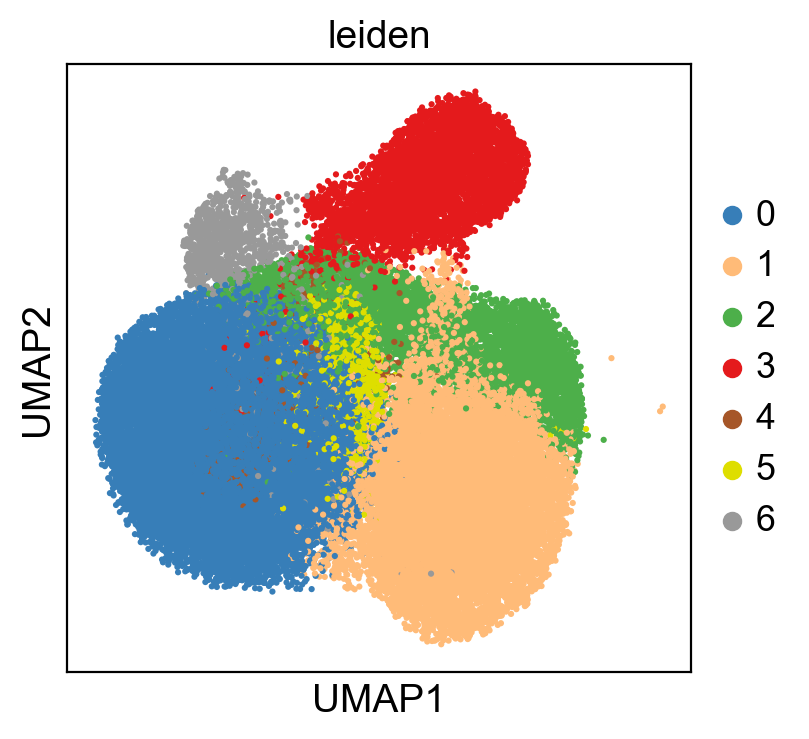

In [18]:
sc.pl.umap(adata, color=['leiden'],vmax=[5,4,30], ncols=3, s=20, palette=CB_color_cycle,
          save='figure_1_leiden.eps')

Batch clustering and clonal expansion

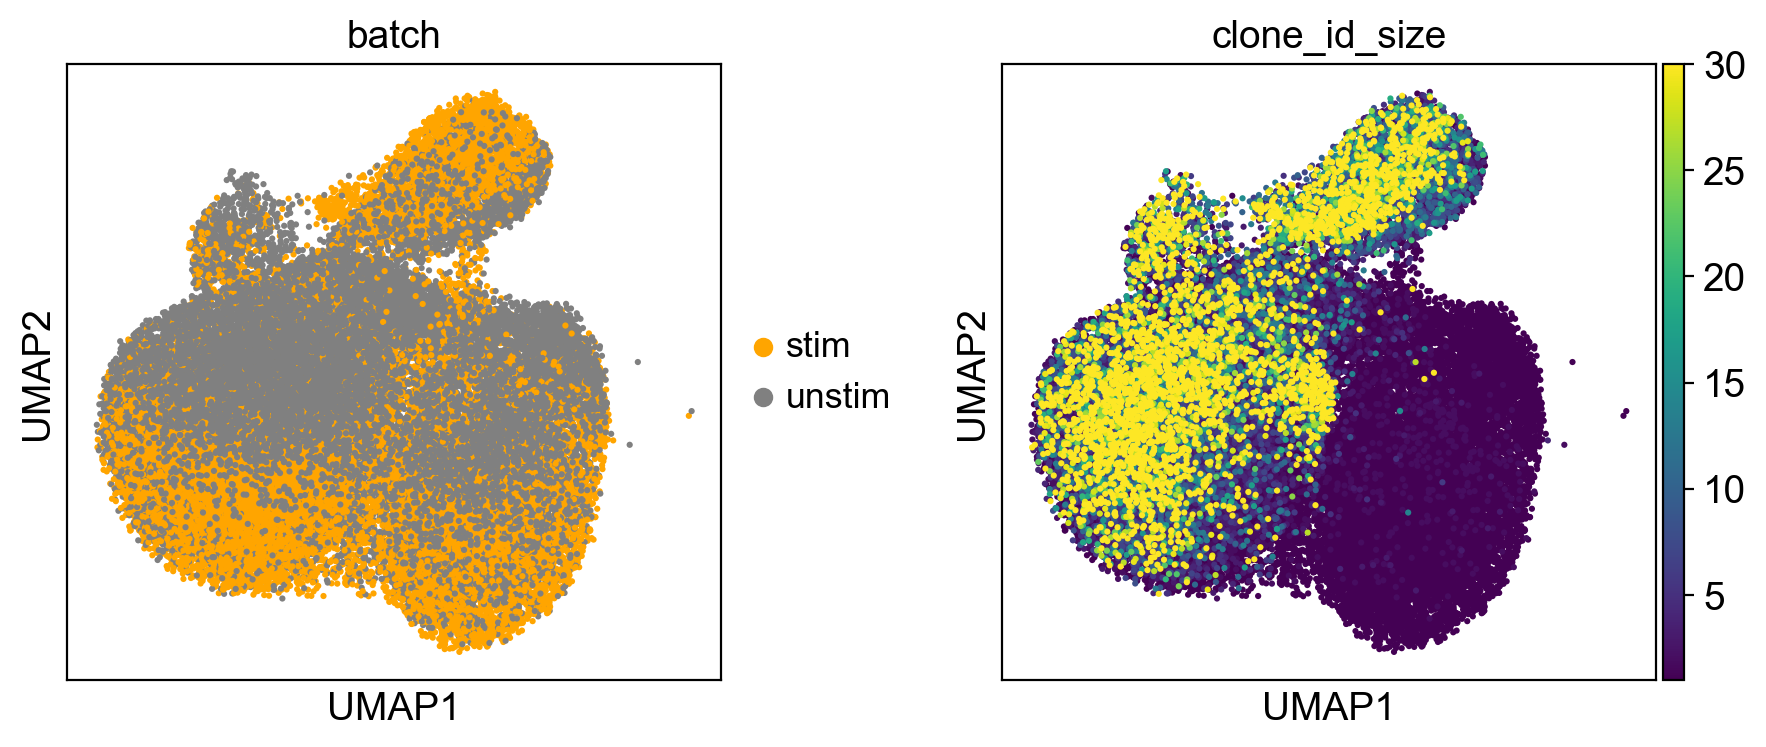

In [19]:
sc.pl.umap(adata, color=['batch','clone_id_size'],vmax=[2,30], ncols=2, s=20, wspace = 0.3,
          save='figure_1_batch_size.eps')


Transcriptomic space CD44hi and multimer isolated clones

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


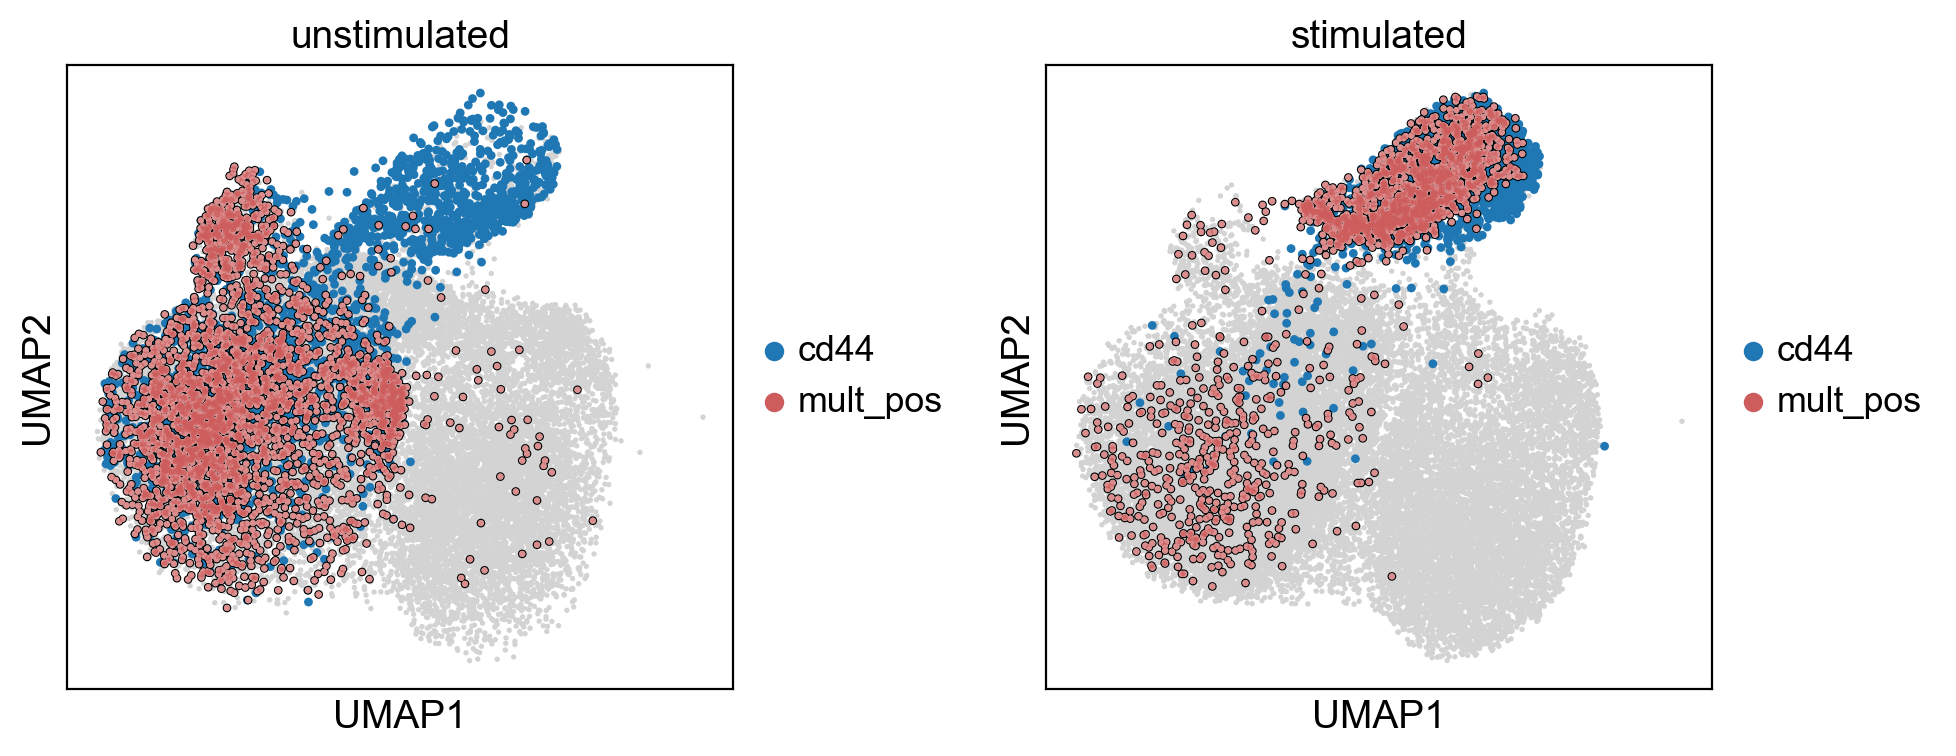

In [20]:
fig,ax=plt.subplots(ncols=2, figsize=(10,4))

#multimer positive clones unstim vs stim
sc.pl.umap(adata[adata.obs.batch=='unstim'], color='batch', groups='siinfekl', ax=ax.reshape(-1)[0], show=False, s=15, legend_loc='None')
sc.pl.umap(adata[adata.obs.batch=='stim'], color='batch', groups='siinfekl', ax=ax.reshape(-1)[1], show=False, s=15, legend_loc='None')

sc.pl.umap(adata[np.logical_and(adata.obs.clone_id.isin(cd44hi_exp),adata.obs.batch=='unstim')],
           color='isolation', show=False, s=40, title='unstimulated', ax=ax.reshape(-1)[0], palette=['tab:blue'],
          )
sc.pl.umap(adata[np.logical_and(adata.obs.clone_id.isin(mult_pos_exp),adata.obs.batch=='unstim')],
           color='multimer', show=False, s=20, title='unstimulated', ax=ax.reshape(-1)[0], palette=['indianred'],
           add_outline=True, outline_width=(0.2, 0.0),outline_color=('black', 'white')
           )

sc.pl.umap(adata[np.logical_and(adata.obs.clone_id.isin(cd44hi_exp),adata.obs.batch=='stim')],
           color='isolation', show=False, s=40, title='stimulated', ax=ax.reshape(-1)[1], palette=['tab:blue'],        
          )
sc.pl.umap(adata[np.logical_and(adata.obs.clone_id.isin(mult_pos_exp),adata.obs.batch=='stim')],
           color='multimer', show=False, s=20, title='stimulated', ax=ax.reshape(-1)[1], palette=['indianred'],
          add_outline=True, outline_width=(0.2, 0.0),outline_color=('black', 'white')
          )


fig.tight_layout()

fig.savefig(save_figure_sc + 'figure1_umap_Multimer_vs_Cd44.svg')

Activation Score CD44hi sorted clones: stimulated and unstimulated state

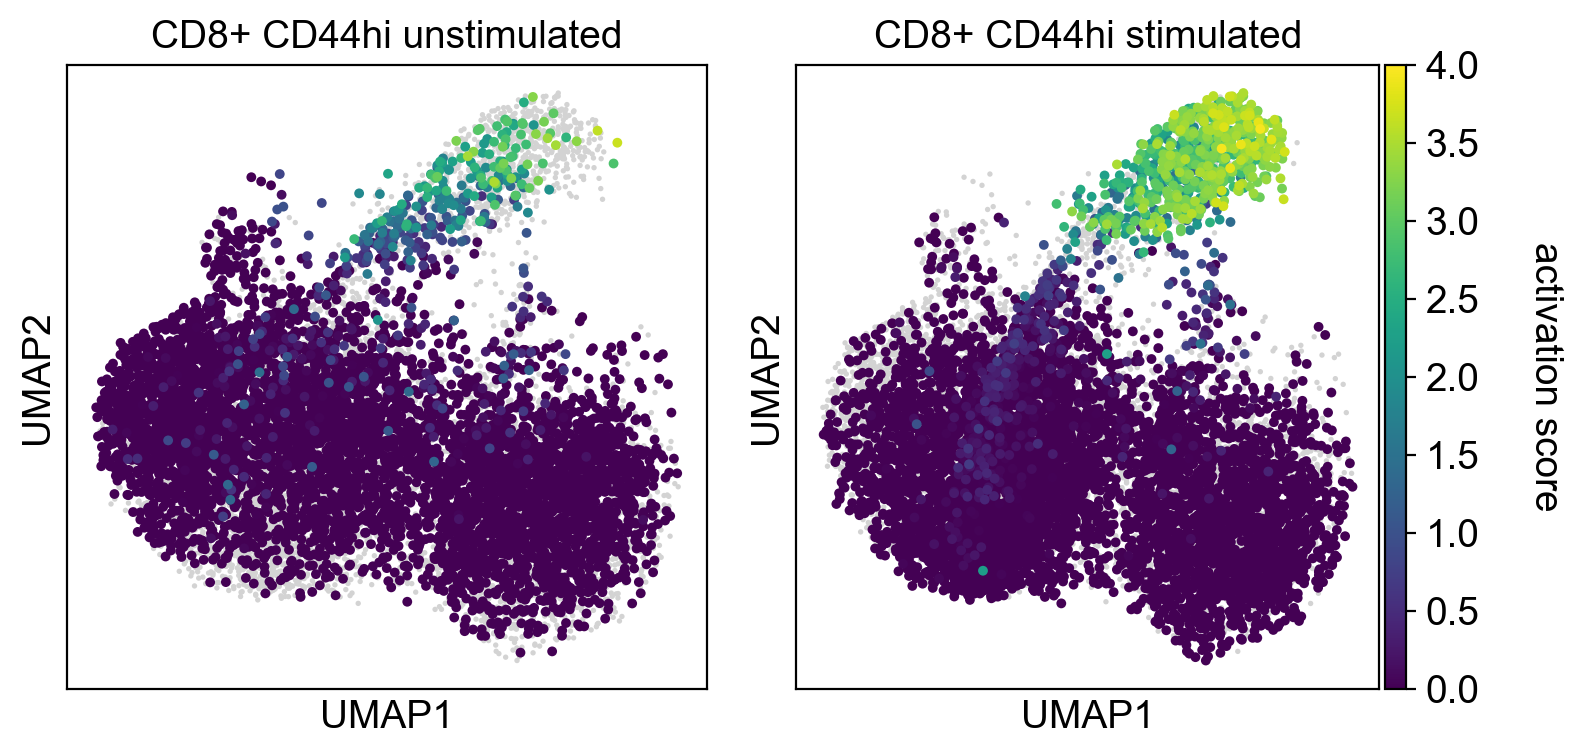

In [21]:
fig,ax=plt.subplots(ncols=2, figsize=(8,4))

sc.pl.umap(adata[adata.obs.exp_group=='2_CD44'], color='batch', groups='siinfekl', ax=ax.reshape(-1)[1], show=False, s=15, legend_loc='None', title='siinfekl Unstim')
sc.pl.umap(adata[adata.obs.exp_group=='2_CD44'], color='batch', groups='siinfekl', ax=ax.reshape(-1)[0], show=False, s=15, legend_loc='None', title='siinfekl Stim')



#unstim SIINFEKL clones
sc.pl.umap(adata[np.logical_and(adata.obs.exp_group=='2_CD44',adata.obs.batch=='unstim')], color='activation_score', 
               ax=ax.reshape(-1)[0], show=False, s=50, color_map='viridis', 
               vmin=0, vmax=4, title='CD8+ CD44hi unstimulated')
ax.reshape(-1)[0].collections[-1].colorbar.remove()

#stim SIINFEKL clones
sc.pl.umap(adata[np.logical_and(adata.obs.exp_group=='2_CD44',adata.obs.batch=='stim')], color='activation_score', 
               ax=ax.reshape(-1)[1], show=False, s=50, color_map='viridis', 
               vmin=0, vmax=4, title='CD8+ CD44hi stimulated')
ax.reshape(-1)[1].collections[-1].colorbar.set_label('activation score', rotation=270, labelpad=30)

fig.tight_layout()

fig.savefig(save_figure_sc + 'figure1_umap_activation_score.eps')



## Differential gene expression

Activation score genes

In [22]:
activation_score = ['Ccl3', 'Xcl1', 'Ccl4', 'Rgs16', 'Ifng', 'Srm', 'Irf8', 'Nr4a1', 'Cd160', 'Tnfrsf9']

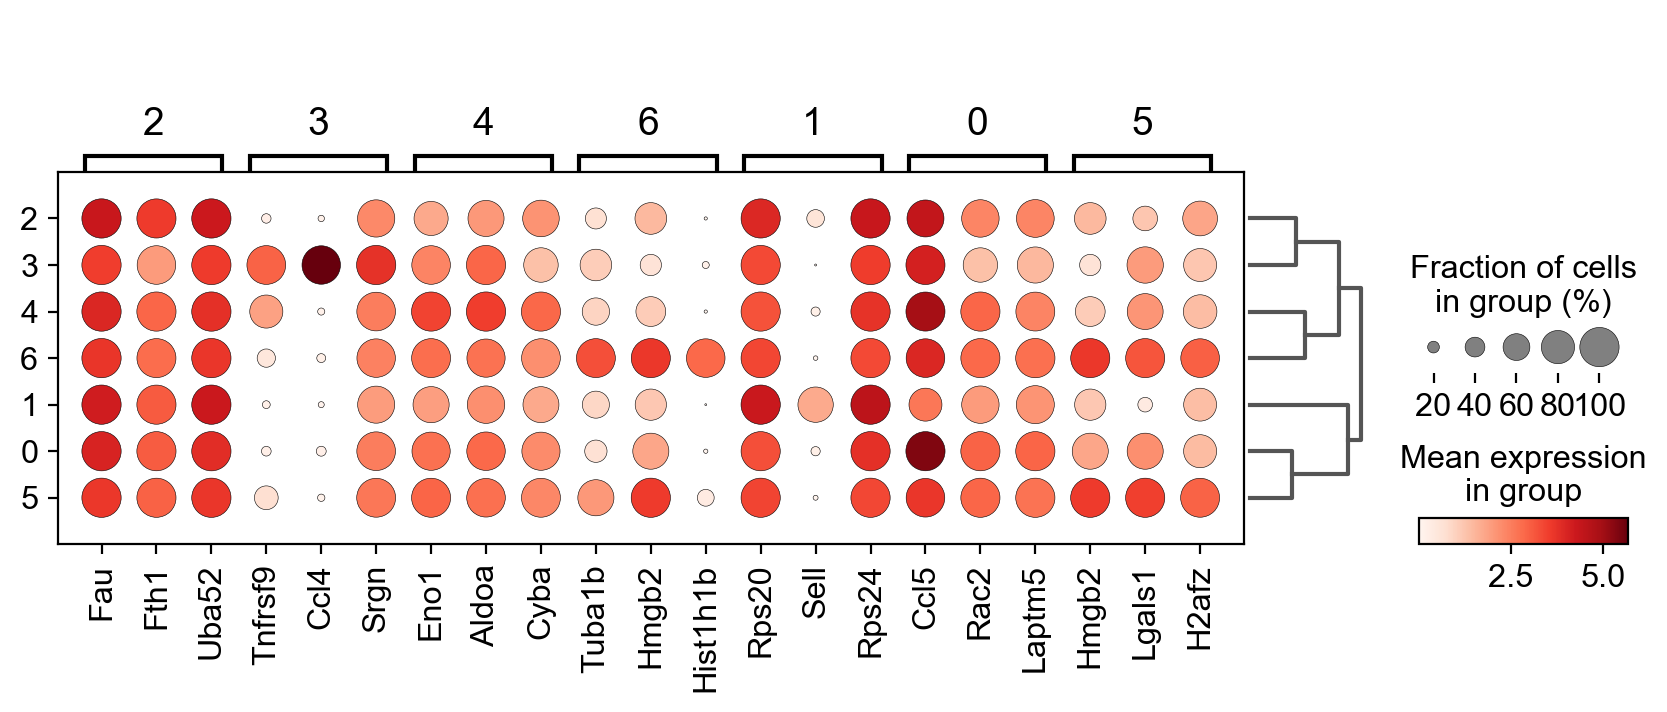

In [23]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=3, save='DEG_leiden.eps')

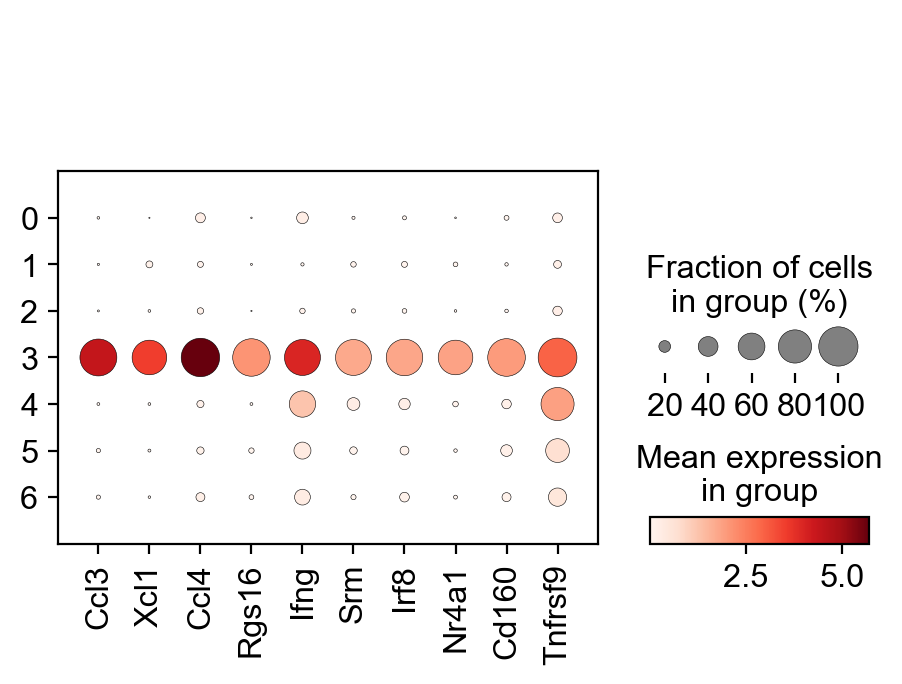

In [24]:
sc.pl.dotplot(adata, activation_score, groupby='leiden', save='activation_genes.eps')

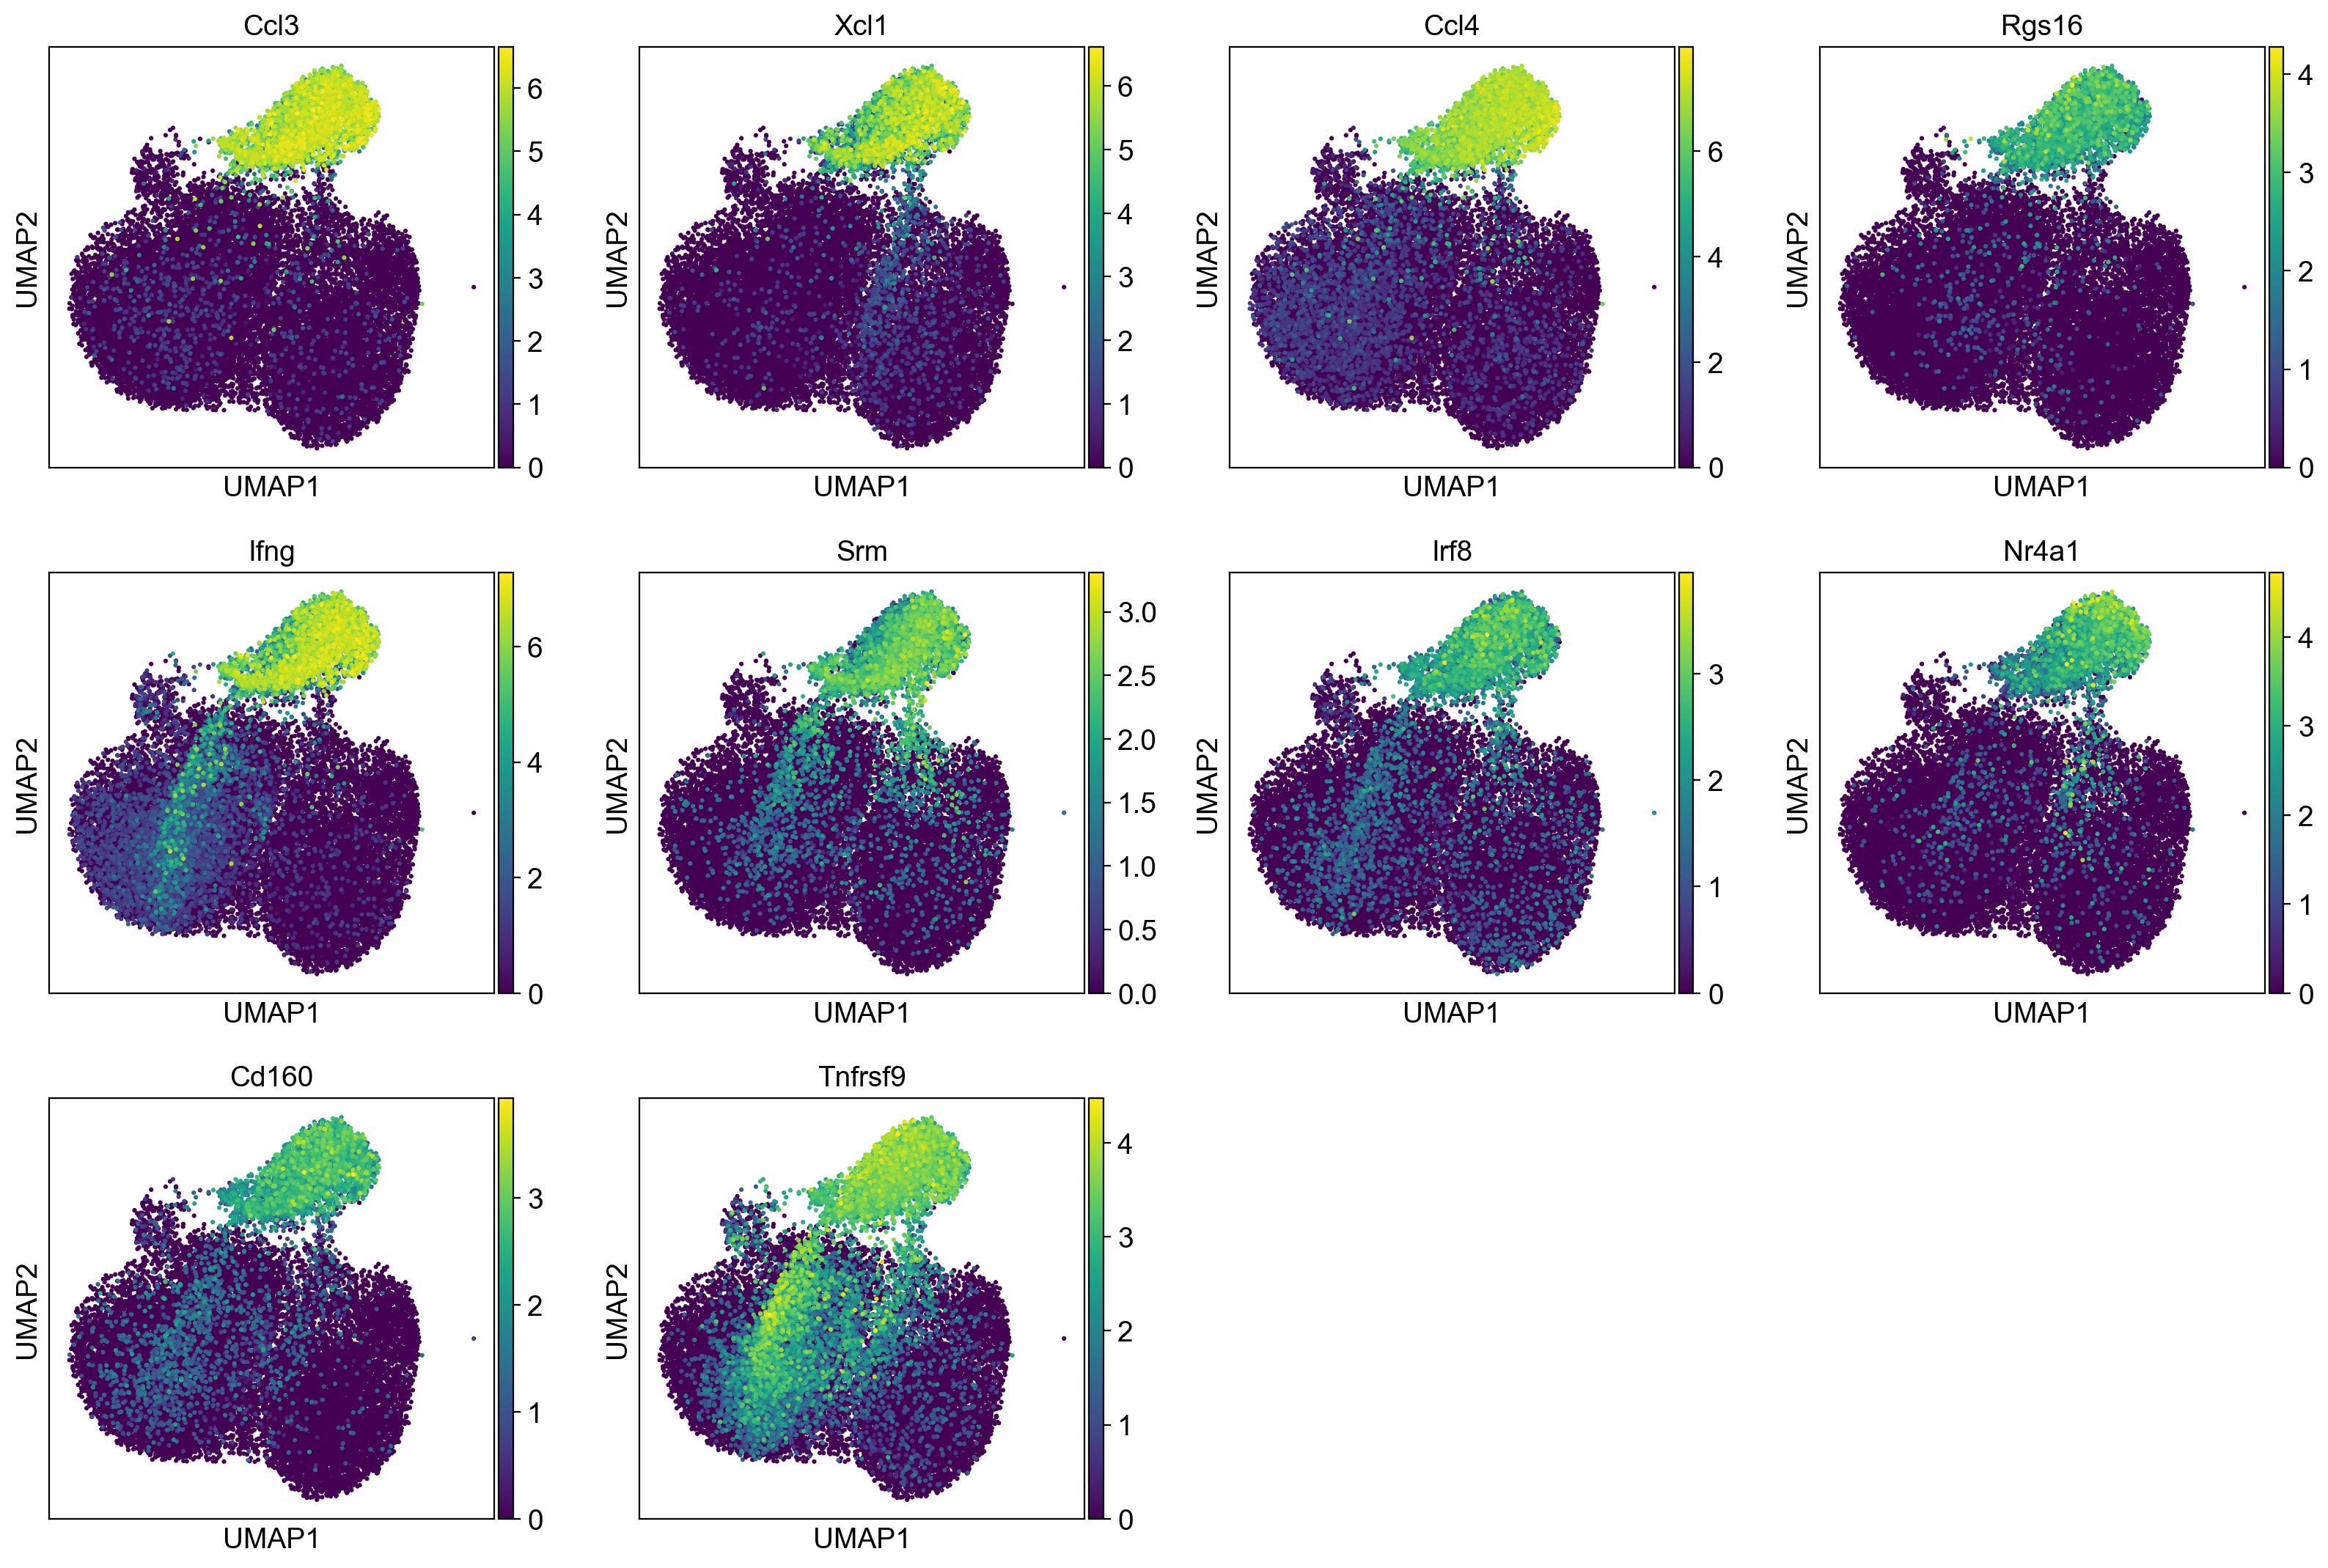

In [25]:
sc.pl.umap(adata[adata.obs.batch=='stim'], color=activation_score, ncols=4, s=20,
          save='_activation_score_stim_umaps.eps')

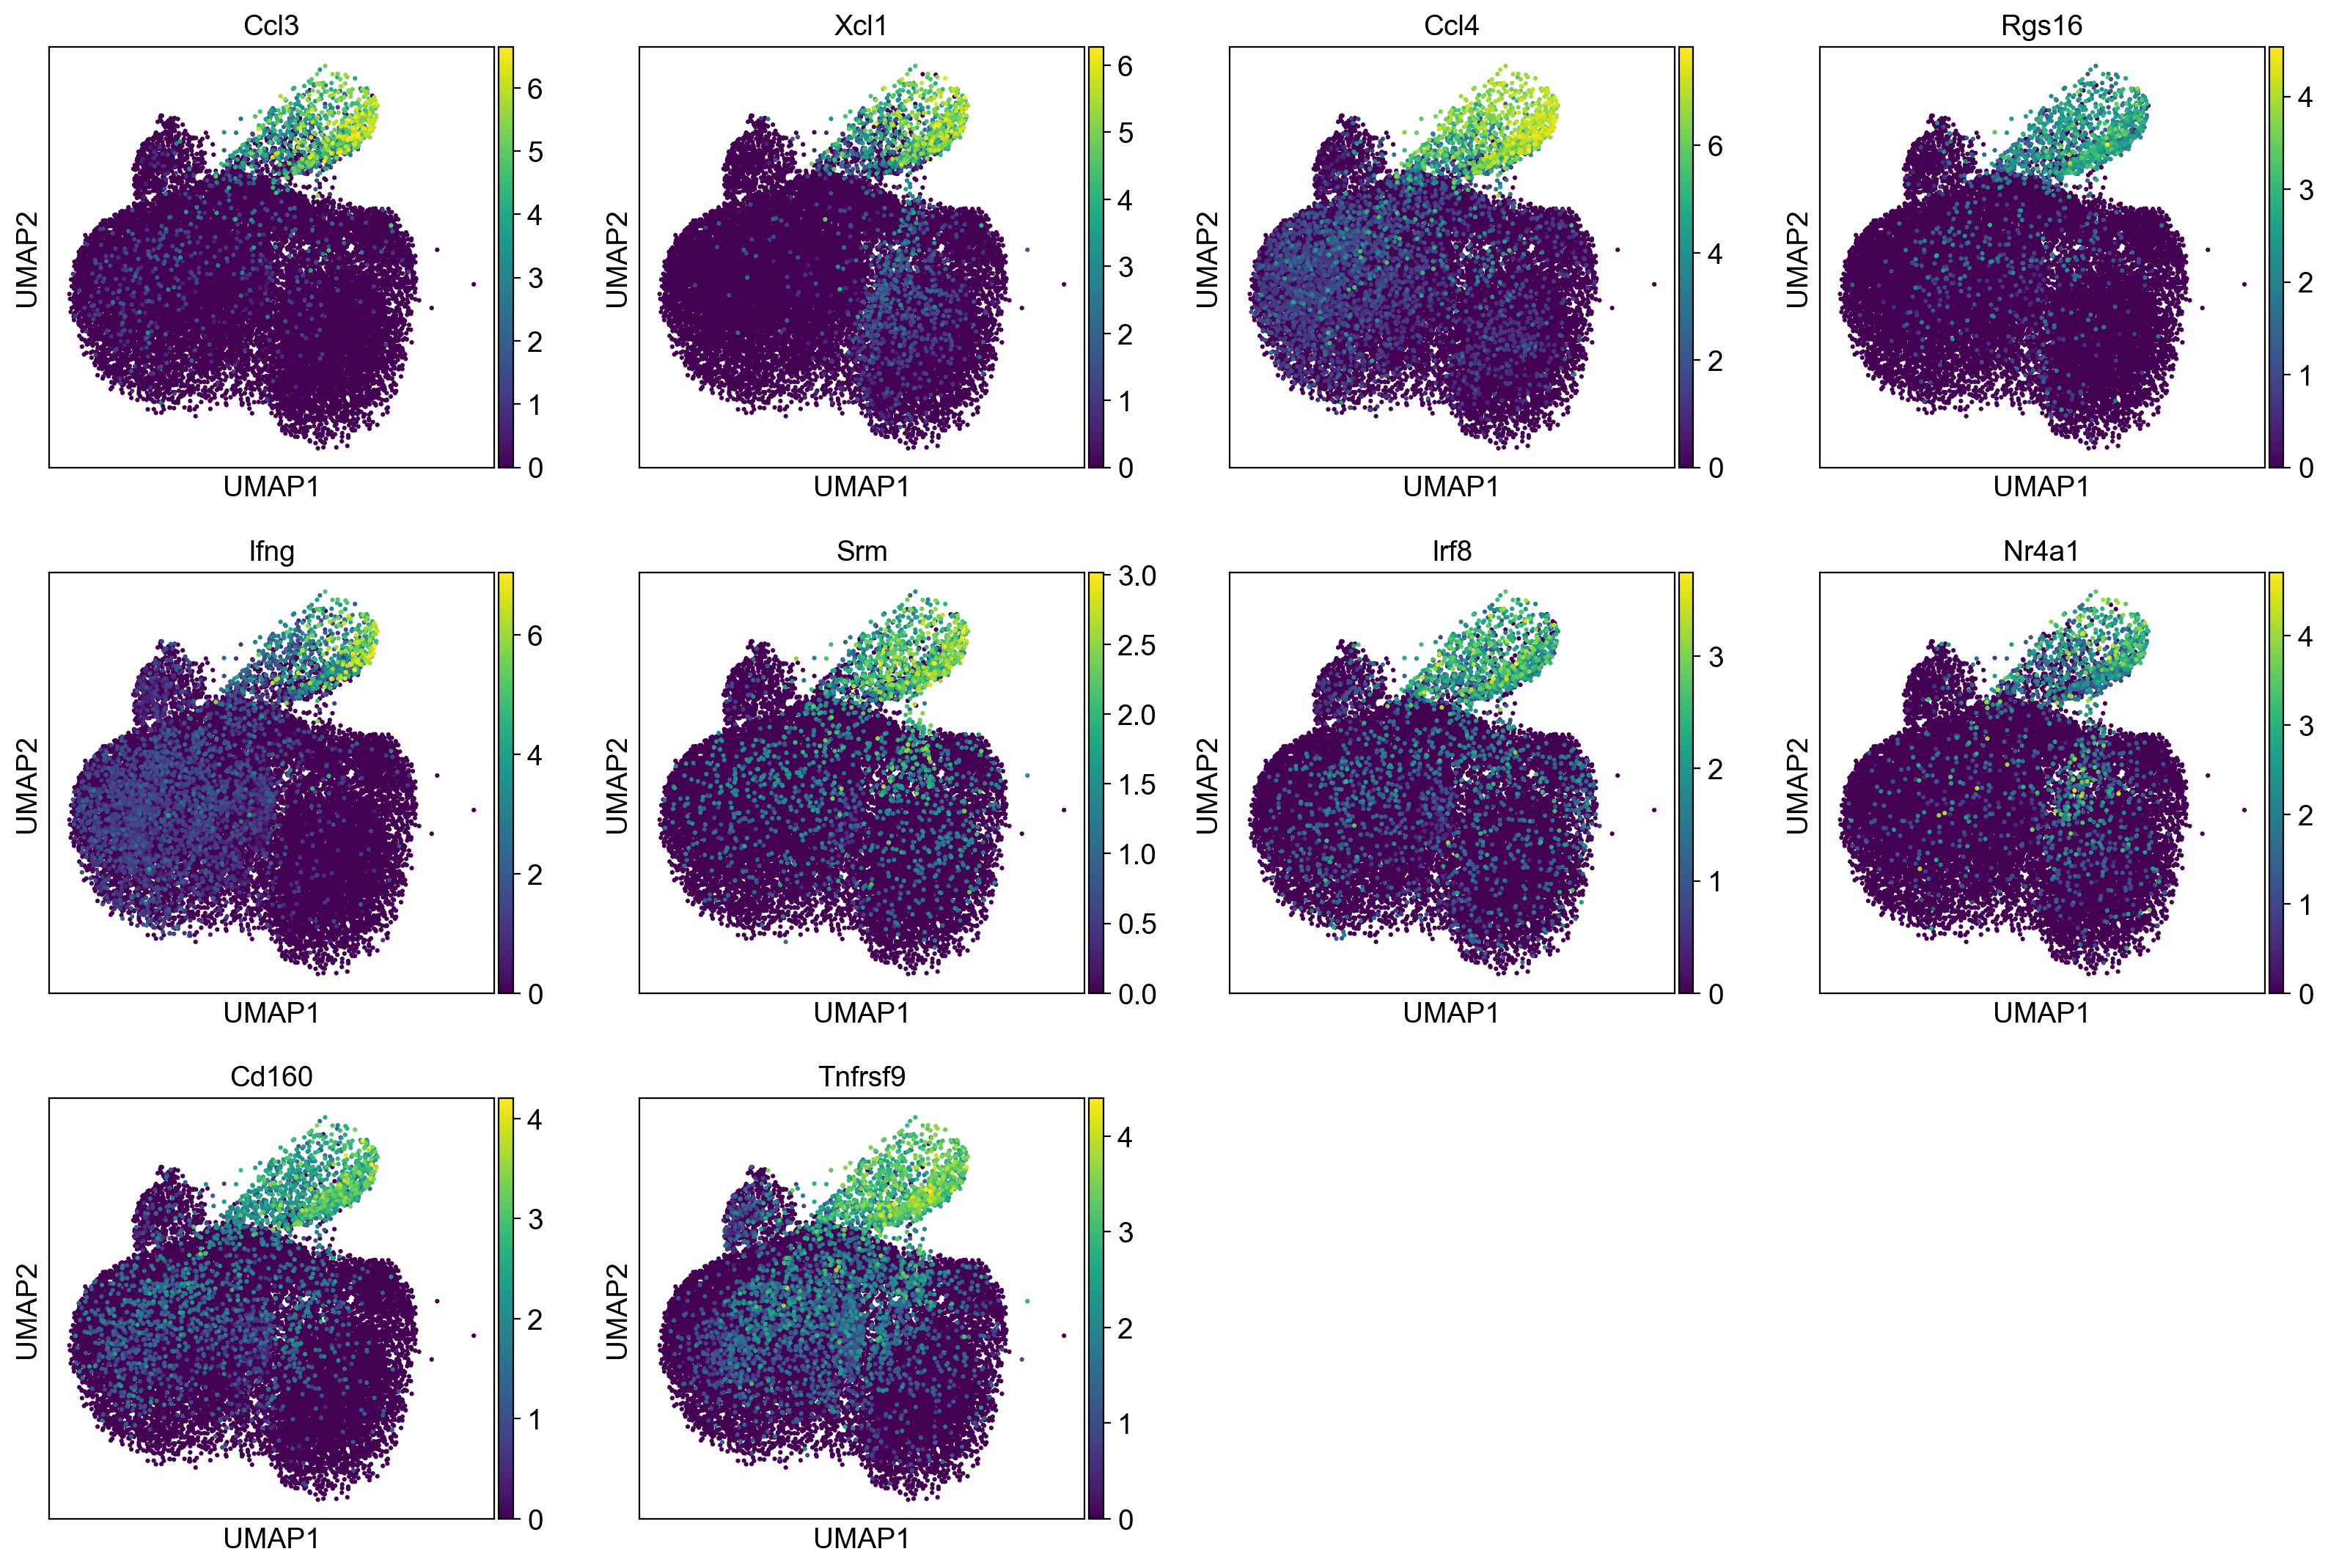

In [26]:
sc.pl.umap(adata[adata.obs.batch=='unstim'], color=activation_score, ncols=4, s=20,
          save='_activation_score_unstim_umaps.eps')

## Sequence table SIINFEKL-reactive clonotypes

In [27]:
df = adata.obs[np.logical_and(adata.obs.siinfekl=='siinfekl_specific',adata.obs.clone_id_size>1)].groupby('clone_id').agg(
    clone_size = ('clone_id_size','first'),
    cdr3a_aa = ('IR_VJ_1_junction_aa','first'),
    cdr3b_aa = ('IR_VDJ_1_junction_aa','first'),
    cdr3a_nt = ('IR_VJ_1_junction','first'),
    cdr3b_nt = ('IR_VDJ_1_junction','first'),
    alpha_V = ('IR_VJ_1_v_call','first'),
    alpha_J = ('IR_VJ_1_j_call','first'),
    alpha_C = ('IR_VJ_1_c_call','first'),
    beta_V = ('IR_VDJ_1_v_call','first'),
    beta_D = ('IR_VDJ_1_d_call','first'),
    beta_J = ('IR_VDJ_1_j_call','first'),
    beta_C = ('IR_VDJ_1_c_call','first'),  
    mouse = ('mouse','first'),

)
df = df.dropna()
df.to_csv(save_csv+'siinfekl_reactive_clonotypes_table.csv')

## Gini Index

adapted from Van der Geest et al., 2015, Quantifying Distribution of Flow Cytometric
TCR-Vβ Usage with Economic Statistics, PLOS One, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4414620/

#### CD44hi sorted clones

Calculations of gini index include random draw of control groups of equal amount of clonotypes compared to antigen-reactive or multimer positive clones

In [28]:

gini_unspec = []
for mouse in adata.obs.mouse[adata.obs.exp_group.isin(cd44_list)].unique().tolist():
    df = adata.obs[np.logical_and(adata.obs.mouse==mouse,adata.obs.siinfekl=='unspecific')].groupby('clone_id').agg(
        clone_size = ('clone_size_mouse','first'),
    )
    df = df.dropna()
    df=df.sort_values(by='clone_size')
    df['cum_tcr']=1/len(df)*100
    df['cum_tcr']=np.cumsum(df.cum_tcr.tolist())
    df['t_cell_tcr']=df.clone_size/adata[adata.obs.mouse==mouse].n_obs*100
    df['cum_t_cell_tcr']=np.cumsum(df.t_cell_tcr.tolist())
    df['norm_cum_t_cell_tcr']=df.cum_t_cell_tcr*(100/max(df.cum_t_cell_tcr.tolist()))
    df['surface']=df.clone_size
    df['surface'][0]=df.cum_tcr[0]*df.norm_cum_t_cell_tcr[0]/2
    for i in range(1,len(df)):
        df['surface'][i]=df.cum_tcr[0]*df.norm_cum_t_cell_tcr[i-1]+((df.norm_cum_t_cell_tcr[i]-df.norm_cum_t_cell_tcr[i-1])*df.cum_tcr[0]/2)

    g = ((100*100/2)-sum(df.surface.tolist()))/(100*100/2)
    gini_unspec.append(g)

In [29]:
gini_spec = []
for mouse in adata.obs.mouse[adata.obs.exp_group.isin(cd44_list)].unique().tolist():
    df = adata.obs[np.logical_and(adata.obs.mouse==mouse,adata.obs.siinfekl=='siinfekl_specific')].groupby('clone_id').agg(
        clone_size = ('clone_size_mouse','first'),
    )
    df = df.dropna()
    df=df.sort_values(by='clone_size')
    df['cum_tcr']=1/len(df)*100
    df['cum_tcr']=np.cumsum(df.cum_tcr.tolist())
    df['t_cell_tcr']=df.clone_size/adata[adata.obs.mouse==mouse].n_obs*100
    df['cum_t_cell_tcr']=np.cumsum(df.t_cell_tcr.tolist())
    df['norm_cum_t_cell_tcr']=df.cum_t_cell_tcr*(100/max(df.cum_t_cell_tcr.tolist()))
    df['surface']=df.clone_size
    df['surface'][0]=df.cum_tcr[0]*df.norm_cum_t_cell_tcr[0]/2
    for i in range(1,len(df)):
        df['surface'][i]=df.cum_tcr[0]*df.norm_cum_t_cell_tcr[i-1]+((df.norm_cum_t_cell_tcr[i]-df.norm_cum_t_cell_tcr[i-1])*df.cum_tcr[0]/2)

    g = ((100*100/2)-sum(df.surface.tolist()))/(100*100/2)
    gini_spec.append(g)

In [30]:
calc=False

In [31]:
if calc == True:
    import random
    #initialize
    gini_unspec_random = []
    for mouse in adata.obs.mouse[adata.obs.exp_group.isin(cd44_list)].unique().tolist():
        all_clonotypes = adata.obs.clone_id[np.logical_and(adata.obs.mouse==mouse,adata.obs.siinfekl=='unspecific')].unique().tolist()
        spec_clonotypes = adata.obs.clone_id[np.logical_and(adata.obs.mouse==mouse,adata.obs.siinfekl=='siinfekl_specific')].unique().tolist()
        random_clonotypes = random.sample(all_clonotypes, k=len(spec_clonotypes))

        df = adata.obs[np.logical_and(np.logical_and(adata.obs.mouse==mouse,adata.obs.siinfekl=='unspecific'),adata.obs.clone_id.isin(random_clonotypes))].groupby('clone_id').agg(
            clone_size = ('clone_size_mouse','first'),
        )
        df = df.dropna()
        df=df.sort_values(by='clone_size')
        df['cum_tcr']=1/len(df)*100
        df['cum_tcr']=np.cumsum(df.cum_tcr.tolist())
        df['t_cell_tcr']=df.clone_size/adata[adata.obs.mouse==mouse].n_obs*100
        df['cum_t_cell_tcr']=np.cumsum(df.t_cell_tcr.tolist())
        df['norm_cum_t_cell_tcr']=df.cum_t_cell_tcr*(100/max(df.cum_t_cell_tcr.tolist()))
        df['surface']=df.clone_size
        df['surface'][0]=df.cum_tcr[0]*df.norm_cum_t_cell_tcr[0]/2
        for i in range(1,len(df)):
            df['surface'][i]=df.cum_tcr[0]*df.norm_cum_t_cell_tcr[i-1]+((df.norm_cum_t_cell_tcr[i]-df.norm_cum_t_cell_tcr[i-1])*df.cum_tcr[0]/2)

        g = ((100*100/2)-sum(df.surface.tolist()))/(100*100/2)
        gini_unspec_random.append(g)

    gini_array = np.array(gini_unspec_random)

    for i in range(100):
        for mouse in adata.obs.mouse[adata.obs.exp_group.isin(cd44_list)].unique().tolist():
            all_clonotypes = adata.obs.clone_id[np.logical_and(adata.obs.mouse==mouse,adata.obs.siinfekl=='unspecific')].unique().tolist()
            spec_clonotypes = adata.obs.clone_id[np.logical_and(adata.obs.mouse==mouse,adata.obs.siinfekl=='siinfekl_specific')].unique().tolist()
            random_clonotypes = random.sample(all_clonotypes, k=len(spec_clonotypes))

            df = adata.obs[np.logical_and(np.logical_and(adata.obs.mouse==mouse,adata.obs.siinfekl=='unspecific'),adata.obs.clone_id.isin(random_clonotypes))].groupby('clone_id').agg(
                clone_size = ('clone_size_mouse','first'),
            )
            df = df.dropna()
            df=df.sort_values(by='clone_size')
            df['cum_tcr']=1/len(df)*100
            df['cum_tcr']=np.cumsum(df.cum_tcr.tolist())
            df['t_cell_tcr']=df.clone_size/adata[adata.obs.mouse==mouse].n_obs*100
            df['cum_t_cell_tcr']=np.cumsum(df.t_cell_tcr.tolist())
            df['norm_cum_t_cell_tcr']=df.cum_t_cell_tcr*(100/max(df.cum_t_cell_tcr.tolist()))
            df['surface']=df.clone_size
            df['surface'][0]=df.cum_tcr[0]*df.norm_cum_t_cell_tcr[0]/2
            for i in range(1,len(df)):
                df['surface'][i]=df.cum_tcr[0]*df.norm_cum_t_cell_tcr[i-1]+((df.norm_cum_t_cell_tcr[i]-df.norm_cum_t_cell_tcr[i-1])*df.cum_tcr[0]/2)

            g = ((100*100/2)-sum(df.surface.tolist()))/(100*100/2)
            gini_unspec_random.append(g)

        gini_array = np.append(gini_array,gini_unspec_random)
        gini_unspec_random = []

In [32]:
if calc == True:
    gini_unspec_random = gini_array.reshape(int(len(gini_array)/30),30).transpose().mean(axis=1).tolist()
    
    spec_list = ['siinfekl']*len(gini_spec)
    unspec_list = ['unspecific']*len(gini_unspec)
    unspec_rand_list = ['unspecific_rand']*len(gini_unspec_random)
    
    df_dict = {'gini': gini_spec+gini_unspec+gini_unspec_random,
           'specificity': spec_list+unspec_list+unspec_rand_list,
          }
    df = pd.DataFrame(df_dict)
    df.to_csv(save_csv+'gini_per_mouse.csv', index=True)

In [33]:
df = pd.read_csv(read_csv+'gini_per_mouse.csv')

Text(0.5, 0, '')

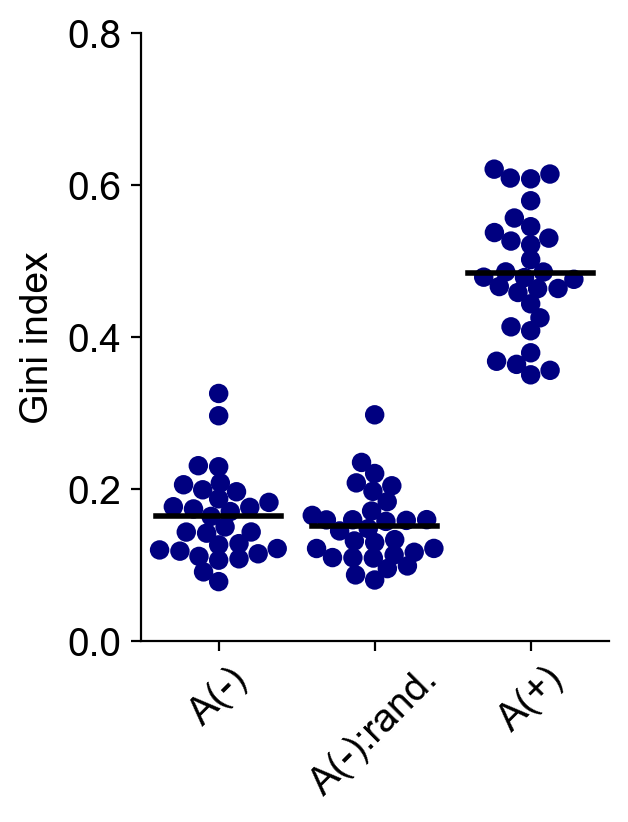

In [34]:
fig, ax = plt.subplots(figsize=(3,4))

ax = sns.swarmplot(x="specificity", y="gini", data=df,
                  order=['unspecific','unspecific_rand','siinfekl'],
                  s=7, color='navy')

ax.grid(False)
ax.tick_params(axis='x', rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0,0.8)

# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="specificity",
            y="gini",
            order=['unspecific','unspecific_rand','siinfekl'],
            data=df,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=ax)
ax.set_xticklabels(['A(-)','A(-):rand.','A(+)'])
ax.set_ylabel('Gini index')
ax.set_xlabel('')

#### Multimer+ sorted clones

In [35]:
gini_unspec = []
for mouse in adata.obs.mouse[adata.obs.exp_group.isin(mult_list)].unique().tolist():
    df = adata.obs[np.logical_and(adata.obs.mouse==mouse,adata.obs.multimer=='mult_neg')].groupby('clone_id').agg(
        clone_size = ('clone_size_mouse','first'),
    )
    df = df.dropna()
    df=df.sort_values(by='clone_size')
    df['cum_tcr']=1/len(df)*100
    df['cum_tcr']=np.cumsum(df.cum_tcr.tolist())
    df['t_cell_tcr']=df.clone_size/adata[adata.obs.mouse==mouse].n_obs*100
    df['cum_t_cell_tcr']=np.cumsum(df.t_cell_tcr.tolist())
    df['norm_cum_t_cell_tcr']=df.cum_t_cell_tcr*(100/max(df.cum_t_cell_tcr.tolist()))
    df['surface']=df.clone_size
    df['surface'][0]=df.cum_tcr[0]*df.norm_cum_t_cell_tcr[0]/2
    for i in range(1,len(df)):
        df['surface'][i]=df.cum_tcr[0]*df.norm_cum_t_cell_tcr[i-1]+((df.norm_cum_t_cell_tcr[i]-df.norm_cum_t_cell_tcr[i-1])*df.cum_tcr[0]/2)

    g = ((100*100/2)-sum(df.surface.tolist()))/(100*100/2)
    gini_unspec.append(g)

In [36]:
#adapted from: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4414620/
gini_spec = []
for mouse in adata.obs.mouse[adata.obs.exp_group.isin(mult_list)].unique().tolist():
    df = adata.obs[np.logical_and(adata.obs.mouse==mouse,adata.obs.multimer=='mult_pos')].groupby('clone_id').agg(
        clone_size = ('clone_size_mouse','first'),
    )
    df = df.dropna()
    df=df.sort_values(by='clone_size')
    df['cum_tcr']=1/len(df)*100
    df['cum_tcr']=np.cumsum(df.cum_tcr.tolist())
    df['t_cell_tcr']=df.clone_size/adata[adata.obs.mouse==mouse].n_obs*100
    df['cum_t_cell_tcr']=np.cumsum(df.t_cell_tcr.tolist())
    df['norm_cum_t_cell_tcr']=df.cum_t_cell_tcr*(100/max(df.cum_t_cell_tcr.tolist()))
    df['surface']=df.clone_size
    df['surface'][0]=df.cum_tcr[0]*df.norm_cum_t_cell_tcr[0]/2
    for i in range(1,len(df)):
        df['surface'][i]=df.cum_tcr[0]*df.norm_cum_t_cell_tcr[i-1]+((df.norm_cum_t_cell_tcr[i]-df.norm_cum_t_cell_tcr[i-1])*df.cum_tcr[0]/2)

    g = ((100*100/2)-sum(df.surface.tolist()))/(100*100/2)
    gini_spec.append(g)

In [37]:
#adapted from: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4414620/
gini_spec_exp = []
for mouse in adata.obs.mouse[adata.obs.exp_group.isin(mult_list)].unique().tolist():
    df = adata.obs[np.logical_and(np.logical_and(adata.obs.mouse==mouse,adata.obs.multimer=='mult_pos'),adata.obs.clone_size_mouse>1)].groupby('clone_id').agg(
        clone_size = ('clone_size_mouse','first'),
    )
    df = df.dropna()
    df=df.sort_values(by='clone_size')
    df['cum_tcr']=1/len(df)*100
    df['cum_tcr']=np.cumsum(df.cum_tcr.tolist())
    df['t_cell_tcr']=df.clone_size/adata[adata.obs.mouse==mouse].n_obs*100
    df['cum_t_cell_tcr']=np.cumsum(df.t_cell_tcr.tolist())
    df['norm_cum_t_cell_tcr']=df.cum_t_cell_tcr*(100/max(df.cum_t_cell_tcr.tolist()))
    df['surface']=df.clone_size
    df['surface'][0]=df.cum_tcr[0]*df.norm_cum_t_cell_tcr[0]/2
    for i in range(1,len(df)):
        df['surface'][i]=df.cum_tcr[0]*df.norm_cum_t_cell_tcr[i-1]+((df.norm_cum_t_cell_tcr[i]-df.norm_cum_t_cell_tcr[i-1])*df.cum_tcr[0]/2)

    g = ((100*100/2)-sum(df.surface.tolist()))/(100*100/2)
    gini_spec_exp.append(g)

In [38]:
calc=False

In [39]:
if calc == True:
    
    #adapted from: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4414620/
    import random
    #initialize
    gini_unspec_random = []
    for mouse in adata.obs.mouse[adata.obs.exp_group.isin(mult_list)].unique().tolist():
        all_clonotypes = adata.obs.clone_id[np.logical_and(adata.obs.mouse==mouse,adata.obs.multimer=='mult_neg')].unique().tolist()
        spec_clonotypes = adata.obs.clone_id[np.logical_and(adata.obs.mouse==mouse,adata.obs.multimer=='mult_pos')].unique().tolist()
        random_clonotypes = random.sample(all_clonotypes, k=len(spec_clonotypes))

        df = adata.obs[np.logical_and(np.logical_and(adata.obs.mouse==mouse,adata.obs.multimer=='mult_neg'),adata.obs.clone_id.isin(random_clonotypes))].groupby('clone_id').agg(
            clone_size = ('clone_size_mouse','first'),
        )
        df = df.dropna()
        df=df.sort_values(by='clone_size')
        df['cum_tcr']=1/len(df)*100
        df['cum_tcr']=np.cumsum(df.cum_tcr.tolist())
        df['t_cell_tcr']=df.clone_size/adata[adata.obs.mouse==mouse].n_obs*100
        df['cum_t_cell_tcr']=np.cumsum(df.t_cell_tcr.tolist())
        df['norm_cum_t_cell_tcr']=df.cum_t_cell_tcr*(100/max(df.cum_t_cell_tcr.tolist()))
        df['surface']=df.clone_size
        df['surface'][0]=df.cum_tcr[0]*df.norm_cum_t_cell_tcr[0]/2
        for i in range(1,len(df)):
            df['surface'][i]=df.cum_tcr[0]*df.norm_cum_t_cell_tcr[i-1]+((df.norm_cum_t_cell_tcr[i]-df.norm_cum_t_cell_tcr[i-1])*df.cum_tcr[0]/2)

        g = ((100*100/2)-sum(df.surface.tolist()))/(100*100/2)
        gini_unspec_random.append(g)

    gini_array = np.array(gini_unspec_random)

    for i in range(100):
        for mouse in adata.obs.mouse[adata.obs.exp_group.isin(mult_list)].unique().tolist():
            all_clonotypes = adata.obs.clone_id[np.logical_and(adata.obs.mouse==mouse,adata.obs.multimer=='mult_neg')].unique().tolist()
            spec_clonotypes = adata.obs.clone_id[np.logical_and(adata.obs.mouse==mouse,adata.obs.multimer=='mult_pos')].unique().tolist()
            random_clonotypes = random.sample(all_clonotypes, k=len(spec_clonotypes))

            df = adata.obs[np.logical_and(np.logical_and(adata.obs.mouse==mouse,adata.obs.multimer=='mult_neg'),adata.obs.clone_id.isin(random_clonotypes))].groupby('clone_id').agg(
                clone_size = ('clone_size_mouse','first'),
            )
            df = df.dropna()
            df=df.sort_values(by='clone_size')
            df['cum_tcr']=1/len(df)*100
            df['cum_tcr']=np.cumsum(df.cum_tcr.tolist())
            df['t_cell_tcr']=df.clone_size/adata[adata.obs.mouse==mouse].n_obs*100
            df['cum_t_cell_tcr']=np.cumsum(df.t_cell_tcr.tolist())
            df['norm_cum_t_cell_tcr']=df.cum_t_cell_tcr*(100/max(df.cum_t_cell_tcr.tolist()))
            df['surface']=df.clone_size
            df['surface'][0]=df.cum_tcr[0]*df.norm_cum_t_cell_tcr[0]/2
            for i in range(1,len(df)):
                df['surface'][i]=df.cum_tcr[0]*df.norm_cum_t_cell_tcr[i-1]+((df.norm_cum_t_cell_tcr[i]-df.norm_cum_t_cell_tcr[i-1])*df.cum_tcr[0]/2)

            g = ((100*100/2)-sum(df.surface.tolist()))/(100*100/2)
            gini_unspec_random.append(g)

        gini_array = np.append(gini_array,gini_unspec_random)
        gini_unspec_random = []

In [40]:
if calc == True:
    gini_unspec_random = gini_array.reshape(int(len(gini_array)/10),10).transpose().mean(axis=1).tolist()
    
    spec_list = ['mult_pos']*len(gini_spec)
    unspec_list = ['mult_neg']*len(gini_unspec)
    unspec_rand_list = ['mult_neg_rand']*len(gini_unspec_random)
    gini_spec_exp_list = ['mult_pos_exp']*len(gini_spec_exp)
    
    df_dict = {'gini': gini_spec_exp + gini_spec + gini_unspec + gini_unspec_random,
           'multimer': gini_spec_exp_list+spec_list+unspec_list+unspec_rand_list,
          }
    df = pd.DataFrame(df_dict)
    df.to_csv(save_csv+'multimer_gini_per_mouse.csv', index=True)

In [41]:
df = pd.read_csv(read_csv+'multimer_gini_per_mouse.csv')

Text(0.5, 0, '')

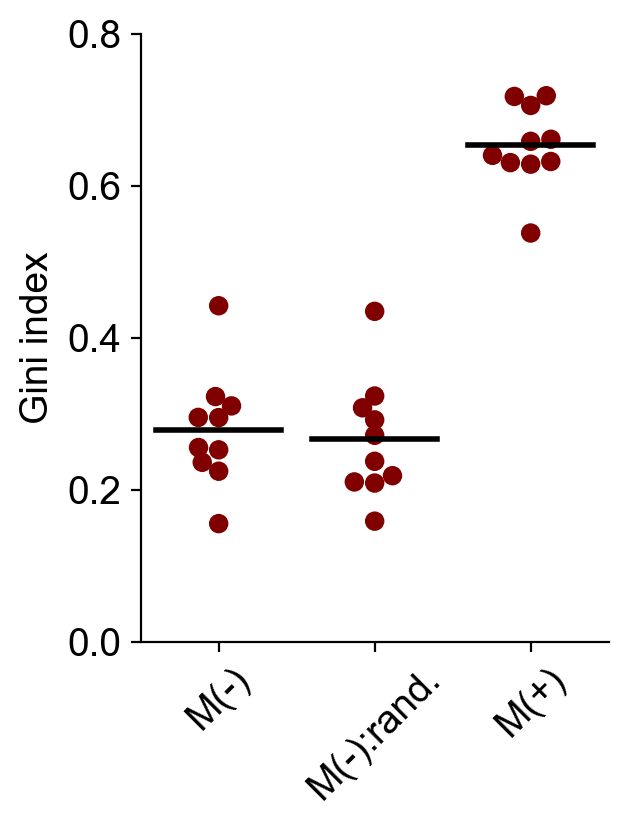

In [42]:
fig, ax = plt.subplots(figsize=(3,4))

ax = sns.swarmplot(x="multimer", y="gini", data=df,
                  order=['mult_neg','mult_neg_rand','mult_pos'],
                  s=7, color='maroon')

ax.grid(False)
ax.tick_params(axis='x', rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0,0.8)

# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="multimer",
            y="gini",
            order=['mult_neg','mult_neg_rand','mult_pos'],
            data=df,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=ax)
ax.set_xticklabels(['M(-)','M(-):rand.','M(+)'])
ax.set_ylabel('Gini index')
ax.set_xlabel('')

## Clonotype distributions by donor

In [43]:
m_list_cd44=adata.obs.mouse[adata.obs.exp_group.isin(cd44_list)].unique().tolist()
m_list_mult=adata.obs.mouse[adata.obs.exp_group.isin(mult_list)].unique().tolist()

Caterogical expansion

In [44]:
clone_size=[1,2,3,5,10,15,20]

In [45]:
df = pd.DataFrame(index=range(len(clone_size)))
df['clone_size']=clone_size

CD44hi sorted

In [46]:
df = pd.DataFrame(index=range(len(clone_size)))
df['clone_size']=clone_size

for mouse in m_list_cd44:
    m=[]
    for size in clone_size:
        cl_s = len(adata.obs.clone_id[np.logical_and(np.logical_and(adata.obs.siinfekl=='siinfekl_specific', adata.obs.mouse==mouse), adata.obs.clone_size_mouse>size)].unique().tolist())
        m.append(cl_s)
    df[mouse]=pd.Series(m)
#df.to_csv(save_csv+'cd44_clonal_expansion.csv')  

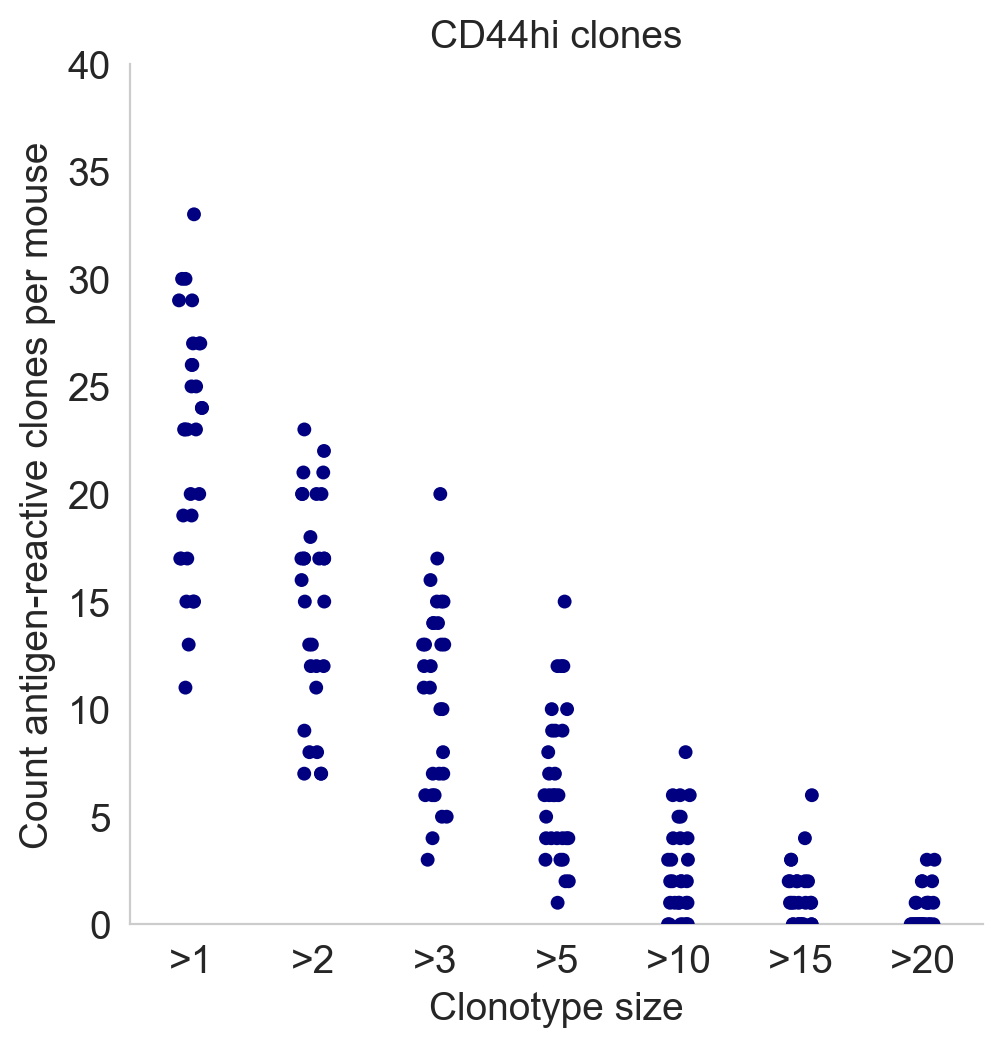

In [47]:
clone_size_label = ['>1','>2','>3','>5','>10','>15','>20']
sns.set_style("whitegrid", {'axes.grid' : False})
g = sns.catplot(data=df.transpose()[1:], color = 'navy').set(title='CD44hi clones')
g = (g.set_axis_labels("Clonotype size","Count antigen-reactive clones per mouse"))
g.set(ylim=(0,40))
g.set_xticklabels(clone_size_label)

Multimer sorted

In [48]:
df = pd.DataFrame(index=range(len(clone_size)))
df['clone_size']=clone_size

for mouse in m_list_mult:
    m=[]
    for size in clone_size:
        cl_s = len(adata.obs.clone_id[np.logical_and(np.logical_and(adata.obs.multimer=='mult_pos', adata.obs.mouse==mouse), adata.obs.clone_size_mouse>size)].unique().tolist())
        m.append(cl_s)
    df[mouse]=pd.Series(m)
#df.to_csv(save_csv+'multimer_clonal_expansion.csv')

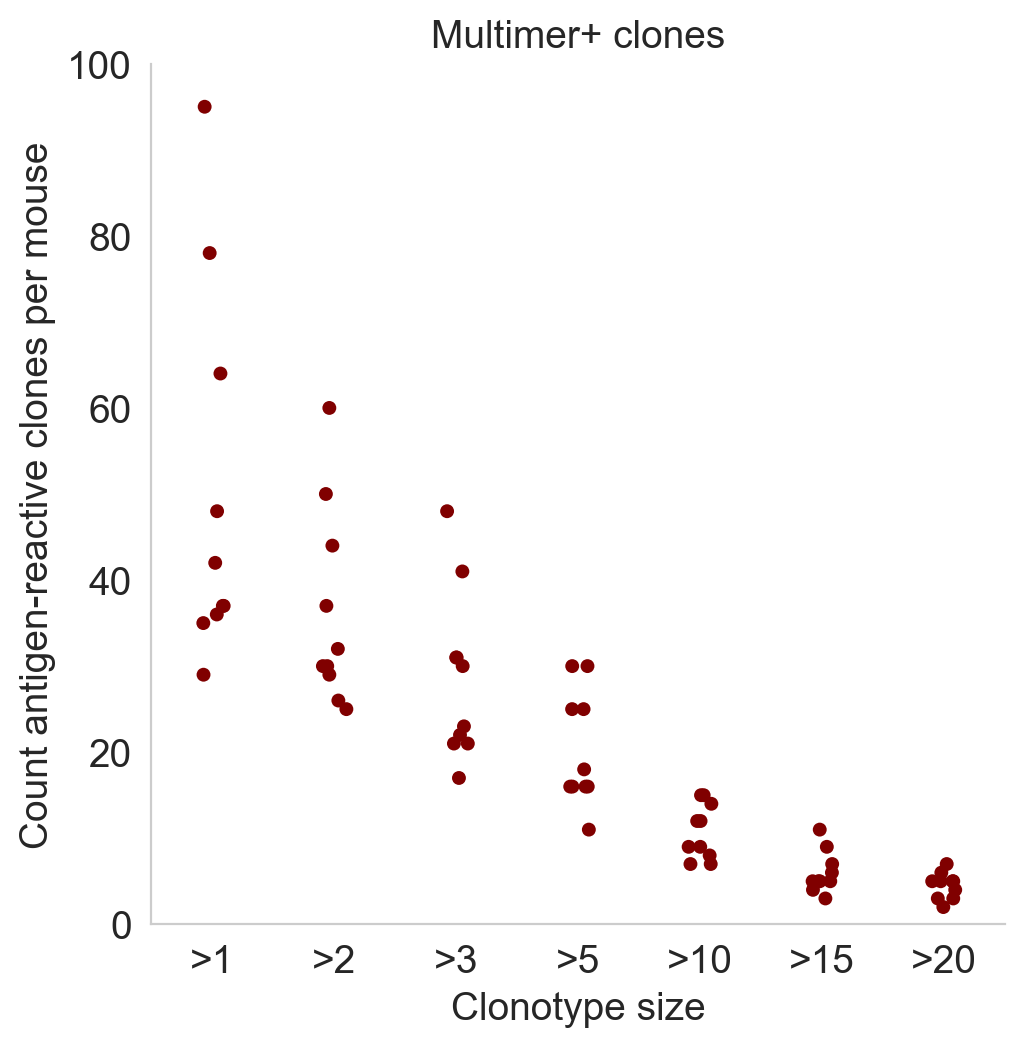

In [49]:
clone_size_label = ['>1','>2','>3','>5','>10','>15','>20']
sns.set_style("whitegrid", {'axes.grid' : False})
g = sns.catplot(data=df.transpose()[1:], color = 'maroon').set(title='Multimer+ clones')
g = (g.set_axis_labels("Clonotype size","Count antigen-reactive clones per mouse"))
g.set(ylim=(0,100))
g.set_xticklabels(clone_size_label)


Clonotype ranking per donor

In [50]:
df = pd.DataFrame(index=range(300))

for mouse in m_list_cd44:
    sizes = adata.obs.clone_id[np.logical_and(adata.obs.siinfekl=='siinfekl_specific', adata.obs.mouse==mouse)].value_counts().tolist()
    filtered = list(filter(lambda num: num != 0, sizes))
    df[mouse]=pd.Series(filtered)
    
for mouse in m_list_mult:
    sizes = adata.obs.clone_id[np.logical_and(adata.obs.multimer=='mult_pos', adata.obs.mouse==mouse)].value_counts().tolist()
    filtered = list(filter(lambda num: num != 0, sizes))
    df[mouse]=pd.Series(filtered)
    
#df.to_csv(save_csv+'clonotype_ranking_all_mice.csv')

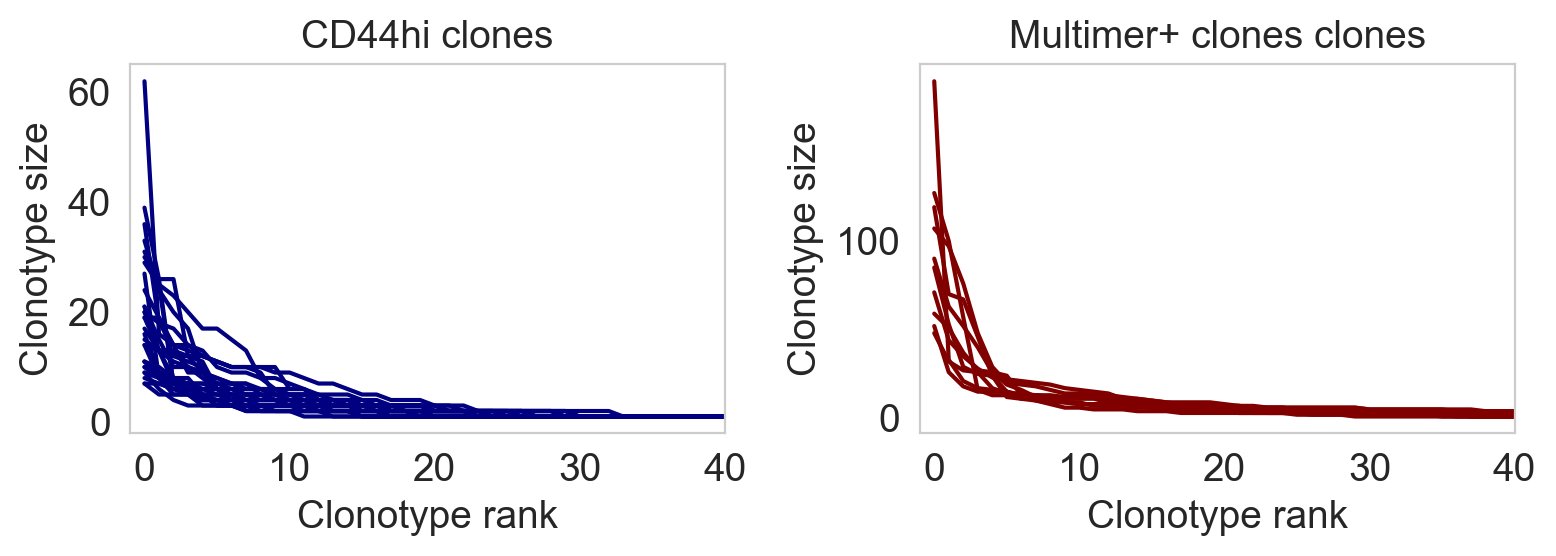

In [51]:
fig, ax = plt.subplots(ncols=2, figsize=(8,3))
df[m_list_cd44].plot.line(color='navy', ax=ax[0])
ax[0].get_legend().remove()
ax[0].set_xlim(-1,40)
ax[0].set_xlabel('Clonotype rank')
ax[0].set_ylabel('Clonotype size')
ax[0].set_title('CD44hi clones')

df[m_list_mult].plot.line(color='maroon', ax=ax[1])
ax[1].get_legend().remove()
ax[1].set_xlim(-1,40)
ax[1].set_xlabel('Clonotype rank')
ax[1].set_ylabel('Clonotype size')
ax[1].set_title('Multimer+ clones clones')

fig.tight_layout()

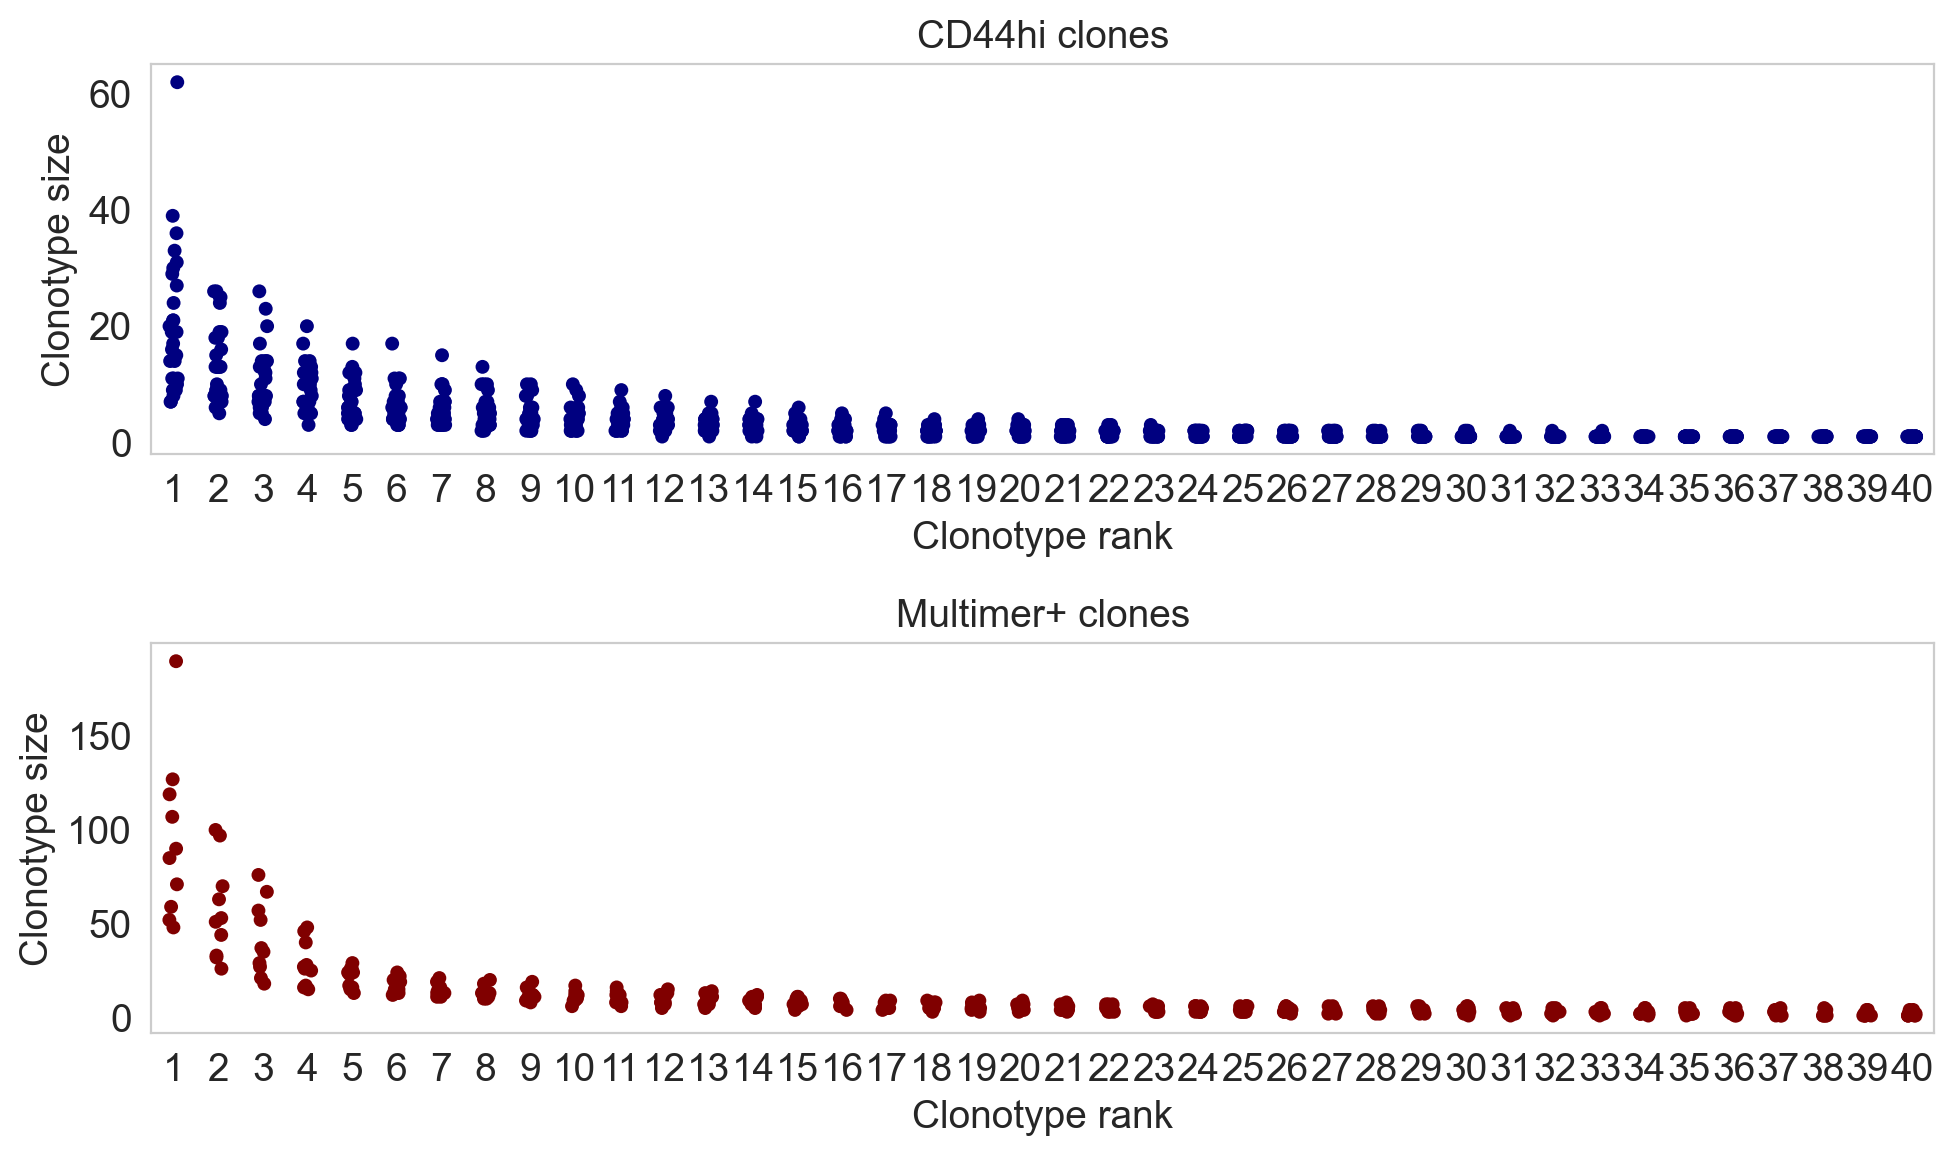

In [52]:
fig, ax = plt.subplots(nrows=2, figsize=(10,6))

df_rank = df[m_list_cd44][:40].transpose()
df_rank = df_rank.melt()#.

sns.stripplot(ax = ax[0],
              data = df_rank,
              x = 'variable',
              y = 'value', color='navy')
ax[0].set_xticklabels(range(1,41))
ax[0].set_xlabel('Clonotype rank')
ax[0].set_ylabel('Clonotype size')
ax[0].set_title('CD44hi clones')

df_rank = df[m_list_mult][:40].transpose()
df_rank = df_rank.melt()#.

sns.stripplot(ax = ax[1],
              data = df_rank,
              x = 'variable',
              y = 'value', color='maroon')
ax[1].set_xticklabels(range(1,41))
ax[1].set_xlabel('Clonotype rank')
ax[1].set_ylabel('Clonotype size')
ax[1].set_title('Multimer+ clones')

fig.tight_layout()